# Integration of BAL samples (v7)

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import scvi
import scanpy as sc
import sc_utils
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os

Global seed set to 0


## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
# Correspondence between study IDs and sample IDs
id_map = pd.read_csv(f"{data_dir}/clinical/BAL_study_sample_id_map.csv")
# List of all BAL samples
BAL_SC_ids = id_map["BAL scRNAseq ID"].tolist()
len(BAL_SC_ids)

33

In [4]:
# Read in BAL count matrices and add metadata
datasets = []
for i in range(len(BAL_SC_ids)):
    ddir = f"{data_dir}/BAL_exon_only/{BAL_SC_ids[i]}/filtered_feature_bc_matrix/"
    datasets.append(sc.read_10x_mtx(path = ddir))
    
    # Record study ID
    datasets[i].obs["Study ID"] = id_map["Study ID"][i]
    
    # Note whether sample is PASC or healthy control
    datasets[i].obs["is_PASC"] = (id_map["Study ID"][i][0:4] == "PASC")
    datasets[i].obs["is_PASC"] = datasets[i].obs["is_PASC"].astype(str).astype('category')
    
    # Trim gene names
    datasets[i].var_names = [x.split("GRCh38_")[-1] for x in datasets[i].var_names]

## Merge datasets

In [5]:
adata = datasets[0].concatenate(datasets[1:], join = "outer", batch_key = "SC ID", batch_categories = BAL_SC_ids)
adata

AnnData object with n_obs × n_vars = 303247 × 36613
    obs: 'Study ID', 'is_PASC', 'SC ID'
    var: 'gene_ids', 'feature_types'

## Run library-wise QC

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top = None, log1p = False, inplace = True)

In [ ]:
mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata, "n_genes_by_counts", groupby = "SC ID")

In [ ]:
mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata, "total_counts", groupby = "SC ID")

## Filter lowly expressed genes

In [9]:
sc.pp.filter_genes(adata, min_counts = 3)
adata

AnnData object with n_obs × n_vars = 303247 × 27603
    obs: 'Study ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'SC ID_colors'

## Normalize data

In [10]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

## Save raw object

In [11]:
adata_raw = adata.copy()
adata_raw.write(f"{data_dir}/BAL_exon_only/raw/adata_raw.h5ad")

## Remove low-quality clusters

In [12]:
adata_old = sc.read_h5ad(f"{data_dir}/01BAL/01integrated_BAL_v5/01integrated_BAL_v5.h5ad")
adata_old = adata_old[~adata_old.obs["leiden_scVI"].isin(['6', '9'])]
adata = adata[adata.obs.index.isin(adata_old.obs.index)]

## Feature selection

In [13]:
# Keep only top 1000 highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 1000,
    subset = True,
    batch_key = "SC ID"
)
# Remove cells with zero expression across HVGs
sc.pp.filter_cells(adata, min_genes = 1)
adata

/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


AnnData object with n_obs × n_vars = 270397 × 1000
    obs: 'Study ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SC ID_colors', 'log1p', 'hvg'
    layers: 'counts'

## Check for HVG overlap between new and old object

In [28]:
len([g for g in adata.var.index if g in adata_old.var.index])

914

Removing the two low quality clusters changes nearly 10% of the HVGs. It thus  seems reasonable to rebuild the model excluding these cells.

## Create scVI model

In [29]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key = "SC ID")
model_adata = scvi.model.SCVI(adata, n_layers = 2, dropout_rate = 0.2, n_latent = 10)
model_adata.save(f"{data_dir}/BAL_exon_only/models/", overwrite = True, save_anndata = True)

## Train model

In [30]:
## The model is trained on a Quest GPU node. ##

In [31]:
adata = sc.read_h5ad(f"{data_dir}/BAL_exon_only/models/adata.h5ad")
model_adata = scvi.model.SCVI.load(f"{data_dir}/BAL_exon_only/models/", adata, prefix = "trained")

INFO     File                                                                                
         /projects/b1038/Pulmonary/cpuritz/PASC/data/BAL_exon_only/models/trainedmodel.pt    
         already downloaded                                                                  


## Store scVI outputs in original anndata

In [32]:
adata.obsm["X_scVI"] = model_adata.get_latent_representation()

## Store normalized values back in the anndata

In [33]:
adata.layers["scvi_normalized"] = model_adata.get_normalized_expression()

## Use scVI latent space for UMAP generation

In [34]:
# Compute neighborhood graph
sc.pp.neighbors(adata, use_rep = "X_scVI")

In [35]:
# Embed neighborhood graph using UMAP
sc.tl.umap(adata, min_dist = 0.3)

In [36]:
# Perform Leiden clustering
sc.tl.leiden(adata, key_added = "leiden_scVI", resolution = 0.75)

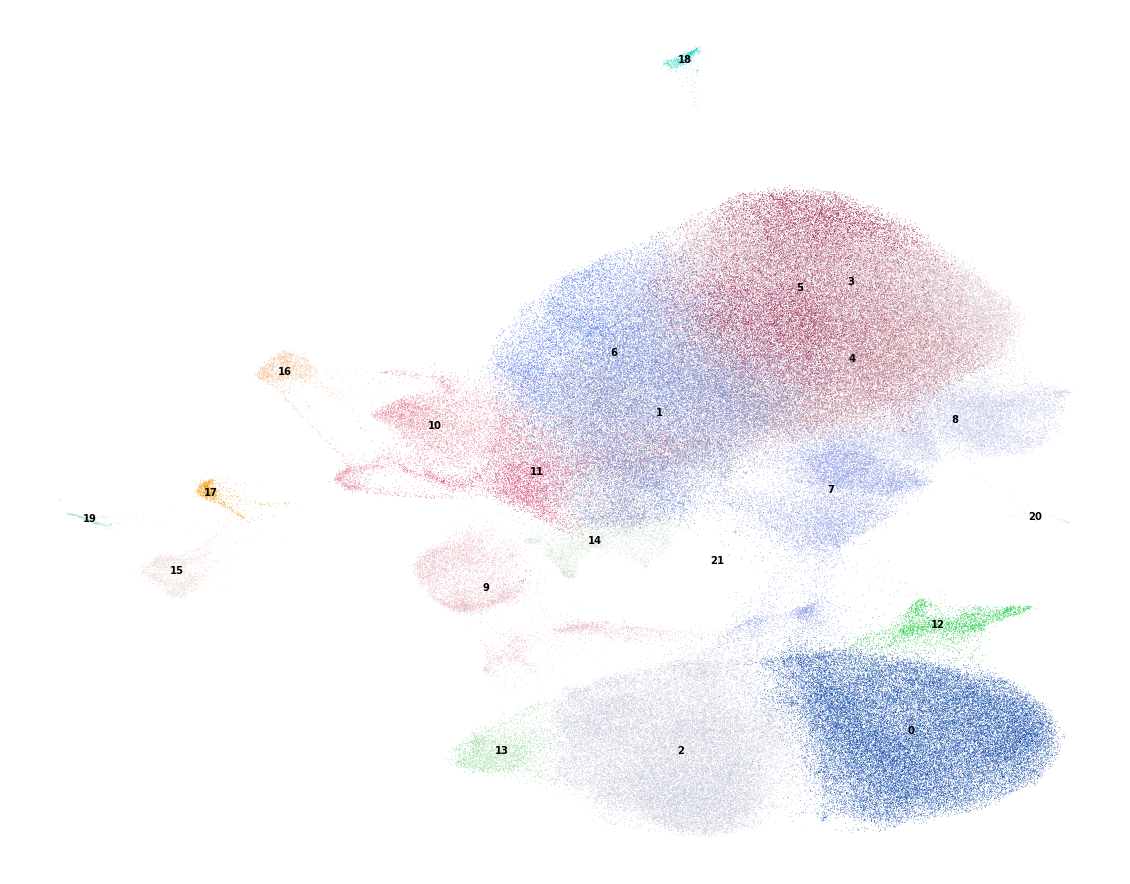

In [37]:
# View UMAP plot
mpl.rcParams["figure.figsize"] = (20, 16)
sc.pl.umap(adata, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "", size = 2)

## Perform QC

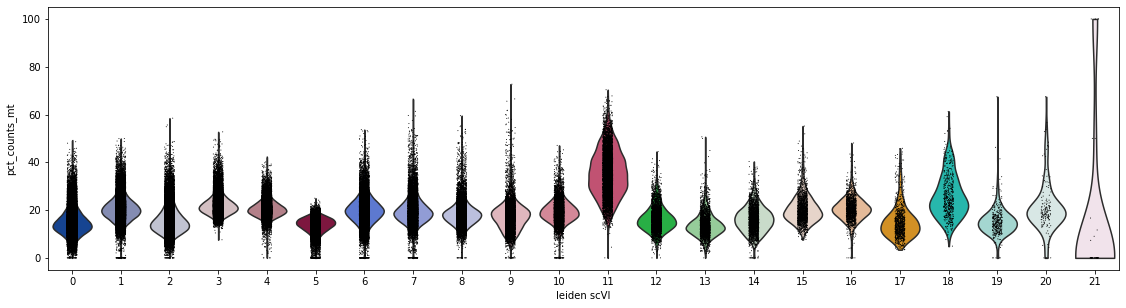

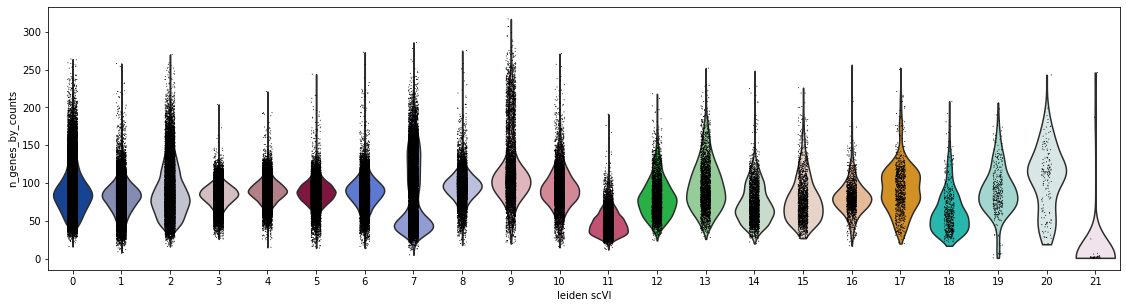

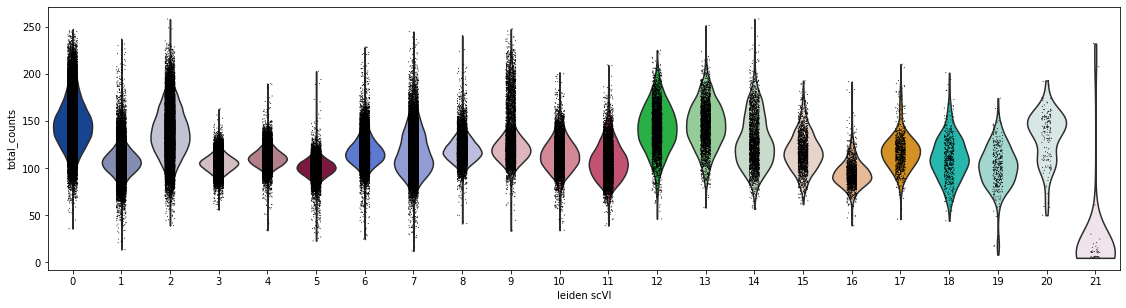

In [38]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

mpl.rcParams["figure.figsize"] = (15, 5)
sc.pl.violin(adata, "pct_counts_mt", groupby = "leiden_scVI")
sc.pl.violin(adata, "n_genes_by_counts", groupby = "leiden_scVI")
sc.pl.violin(adata, "total_counts", groupby = "leiden_scVI")

## Plot sankey diagram

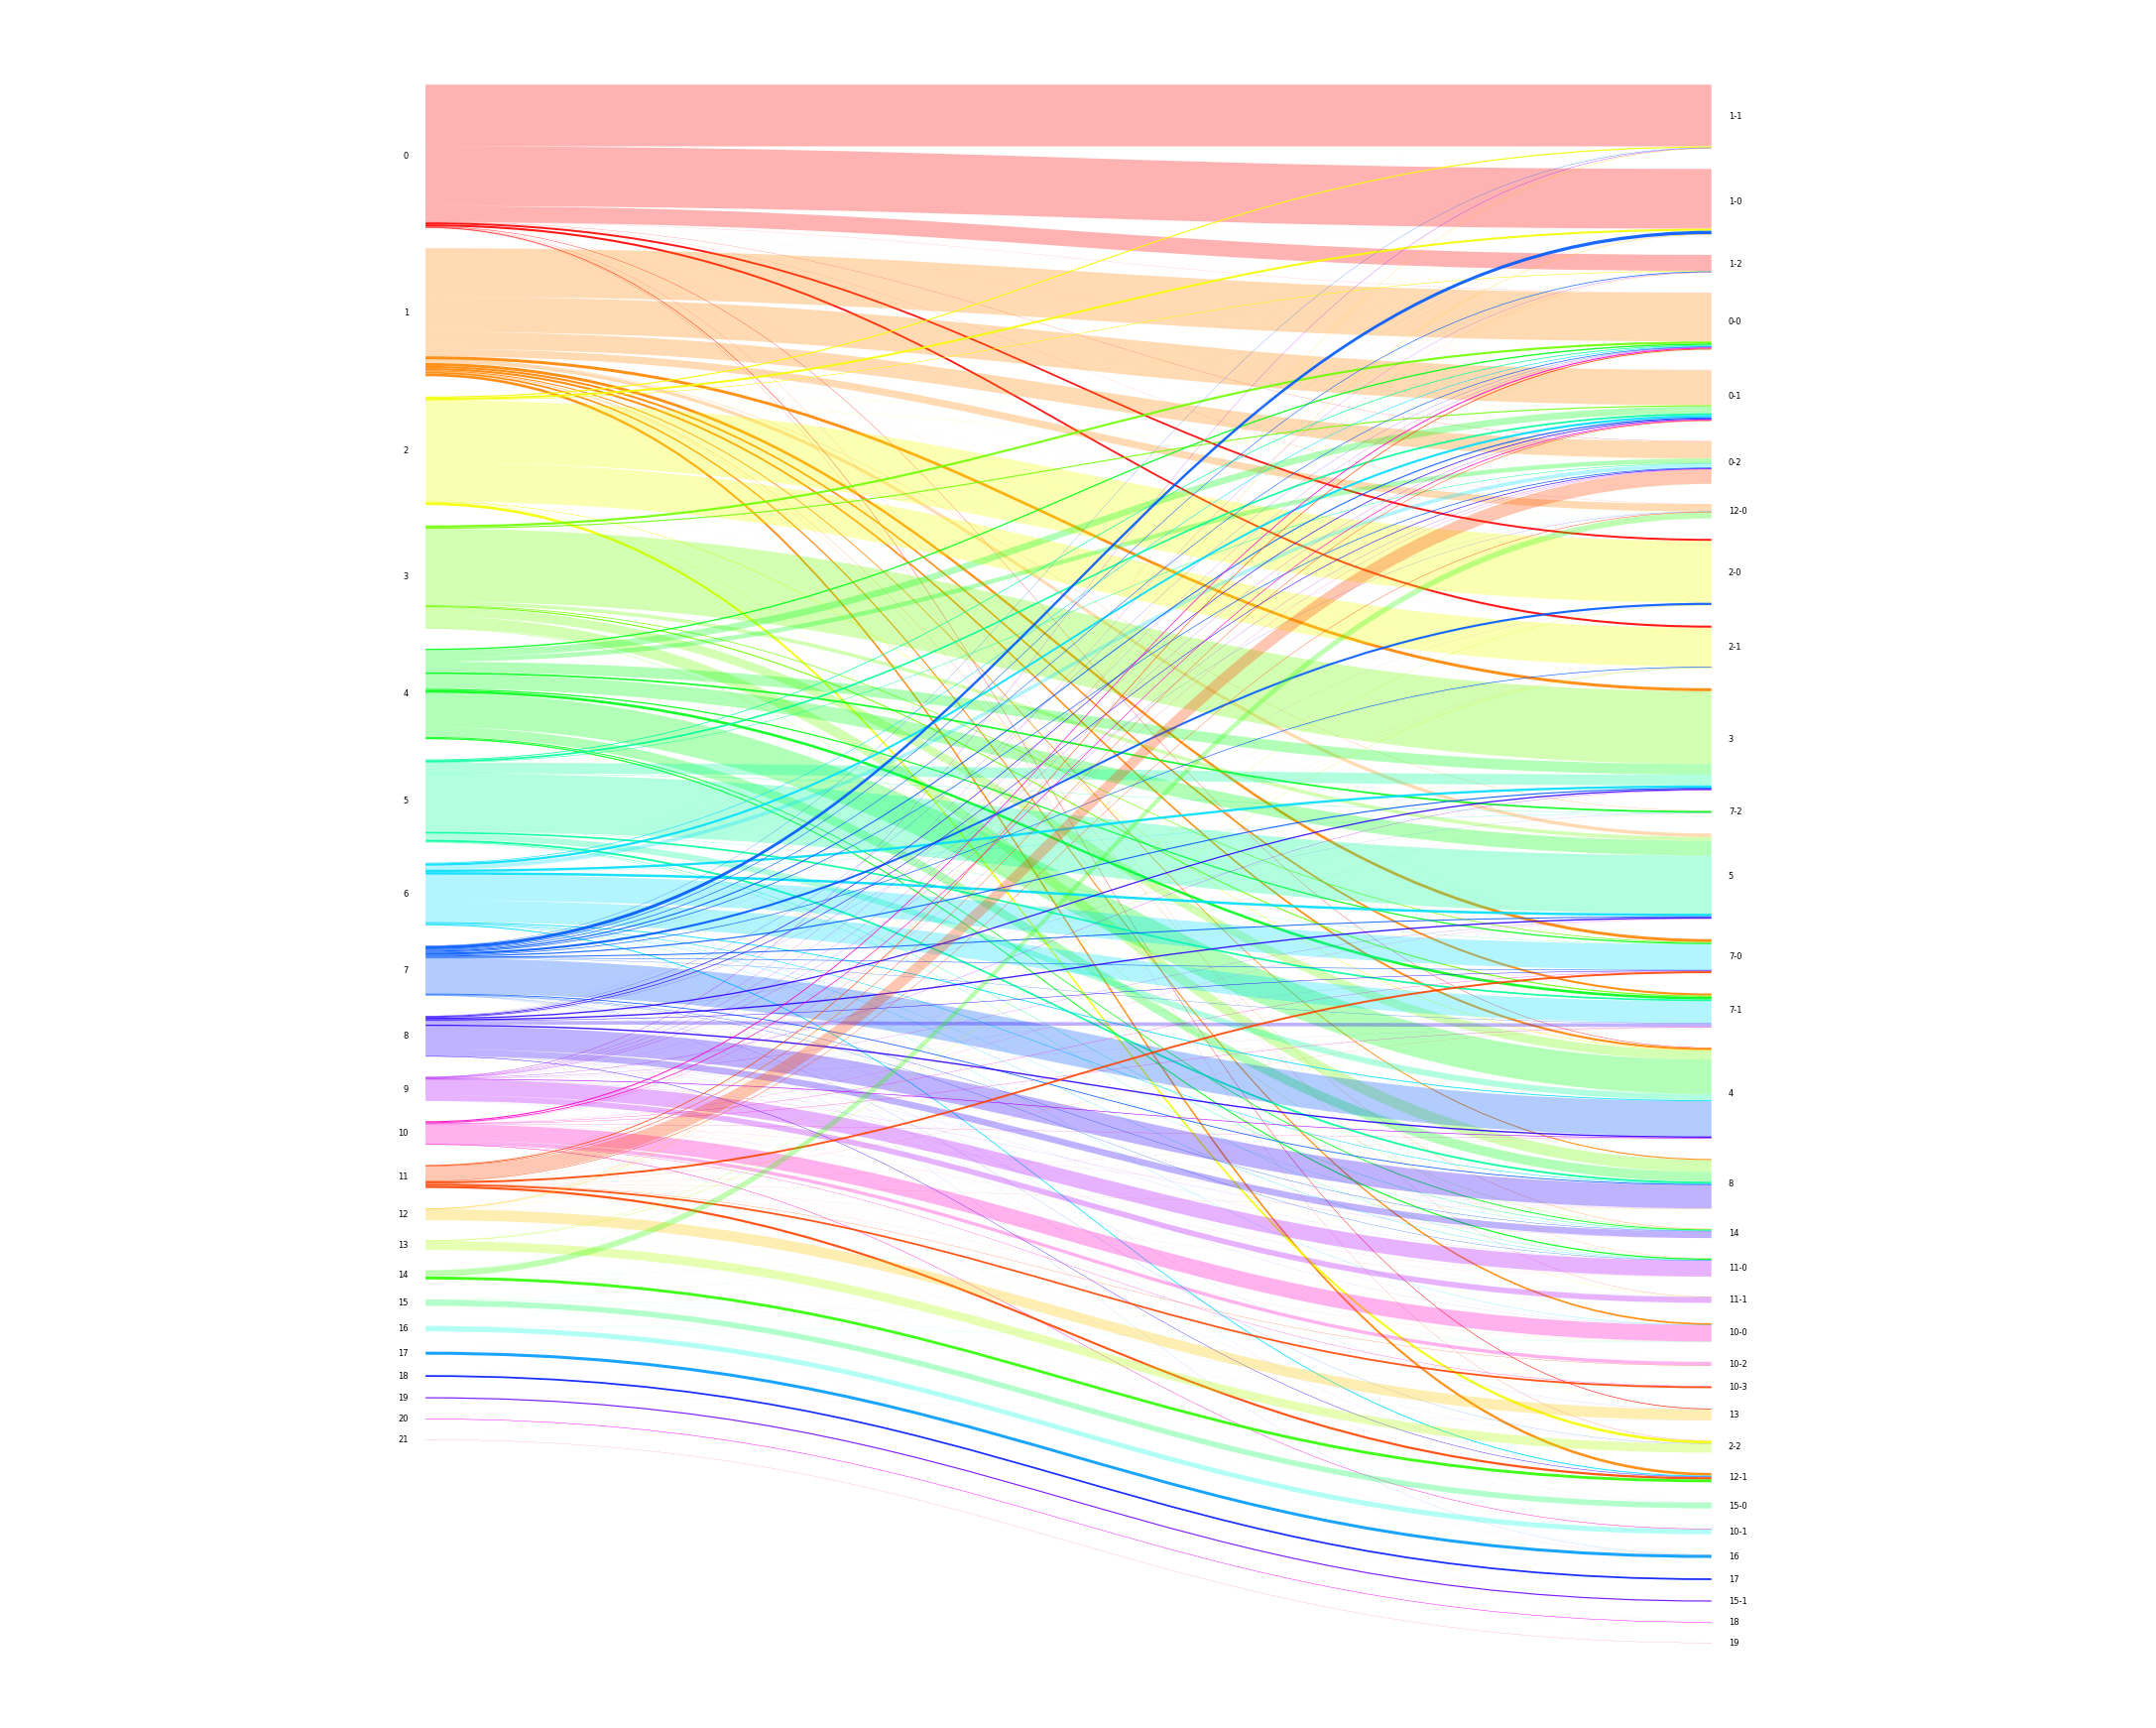

In [43]:
import sankey

adata_old = sc.read_h5ad(f"{data_dir}/01BAL/01integrated_BAL_v6/01integrated_BAL_v6.h5ad")
sankey_clusters = pd.merge(adata_old.obs["subcluster"], adata.obs.leiden_scVI, left_index = True, right_index = True)
sankey_clusters = sankey_clusters.rename(columns = {"leiden_scVI":"new_cluster", "subcluster":"subcluster"})

mpl.rcParams["figure.figsize"] = (30, 24)
sankey.sankey(sankey_clusters.new_cluster, sankey_clusters.subcluster);

## Save output

In [44]:
out_dir = "01BAL/01integrated_BAL_v7"
out_name = "01integrated_BAL_v7"

adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")

## Add cell types
Based on the previous object, cell types can be assigned to some clusters.

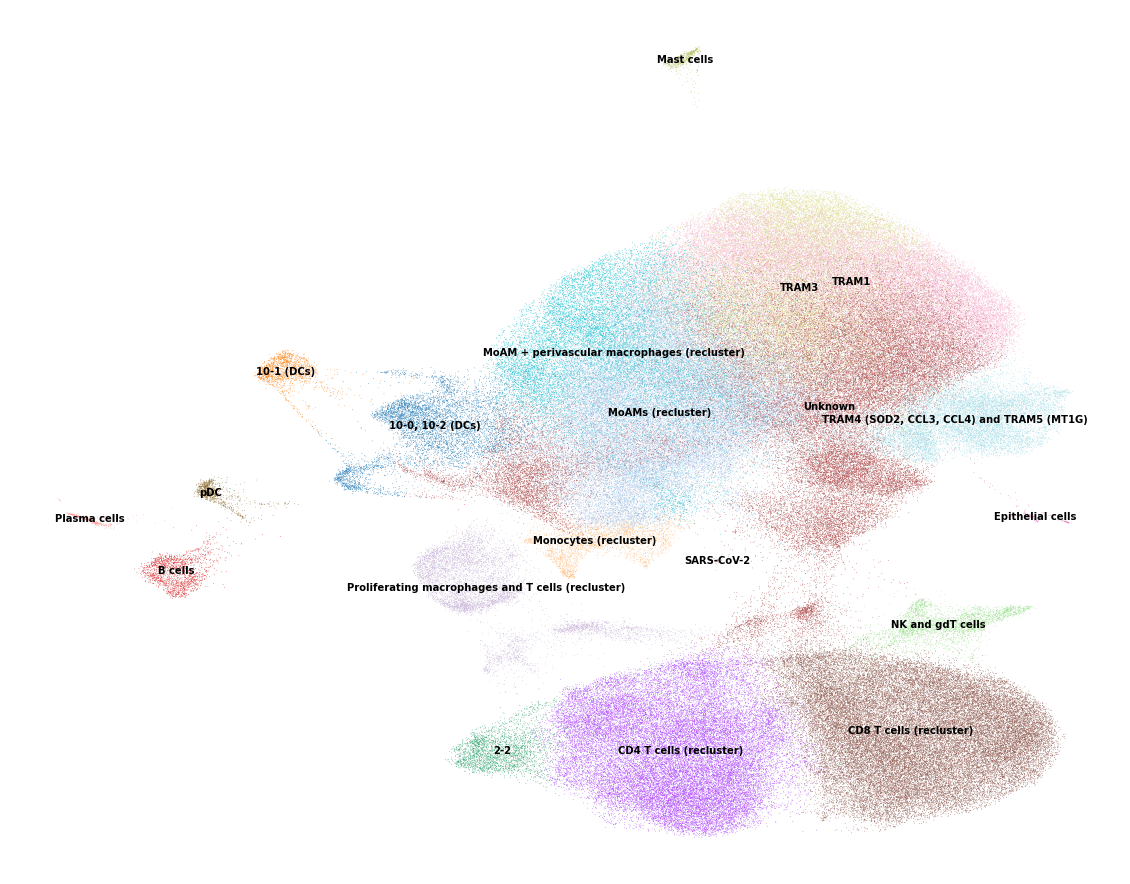

In [126]:
annotations = {"0" : "CD8 T cells (recluster)",
               "1" : "MoAMs (recluster)",
               "2" : "CD4 T cells (recluster)",
               "3" : "TRAM1",
               "4" : "Unknown",
               "5" : "TRAM3",
               "6" : "MoAM + perivascular macrophages (recluster)",
               "7" : "Unknown",
               "8" : "TRAM4 (SOD2, CCL3, CCL4) and TRAM5 (MT1G)",
               "9" : "Proliferating macrophages and T cells (recluster)",
               "10" : "10-0, 10-2 (DCs)",
               "11" : "Unknown",
               "12" : "NK and gdT cells",
               "13" : "2-2",
               "14" : "Monocytes (recluster)",
               "15" : "B cells",
               "16" : "10-1 (DCs)",
               "17" : "pDC",
               "18" : "Mast cells",
               "19" : "Plasma cells",
               "20" : "Epithelial cells",
               "21" : "SARS-CoV-2"}
adata.obs["cell_type"] = adata.obs['leiden_scVI'].map(annotations).astype('category')

mpl.rcParams["figure.figsize"] = (20, 16)
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", frameon = False, title = "", size = 2)

## Resolve clusters
Here we'll attempt to resolve certain clusters.

In [127]:
adata.obs["subcluster"] = adata.obs.leiden_scVI

def recluster(ad, res, ix):
    sc.tl.leiden(ad, key_added = 'subcluster', resolution = res)
    cats = ad.obs['subcluster'].cat
    ad.obs['subcluster'] = cats.rename_categories({c: str(ix) + '-' + c for c in cats.categories})

### Cluster 0 (CD8 T cells)

In [128]:
ix = 0
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.3, ix)
adata.obs.update(adata_sub.obs)

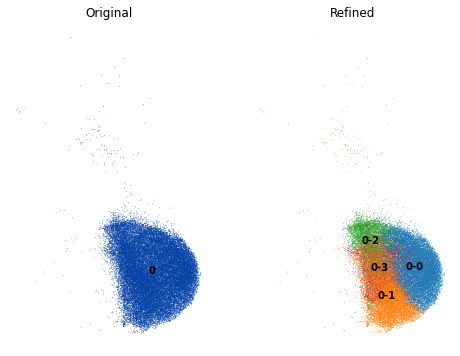

In [130]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

### Cluster 1 (MoAMs)

In [131]:
ix = 1
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.3, ix)
adata.obs.update(adata_sub.obs)

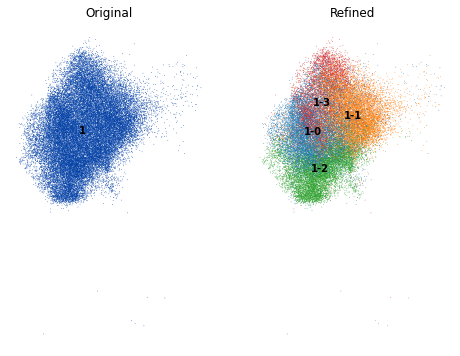

In [132]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

### Cluster 2 (CD4 T cells)

In [133]:
ix = 2
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.25, ix)
adata.obs.update(adata_sub.obs)

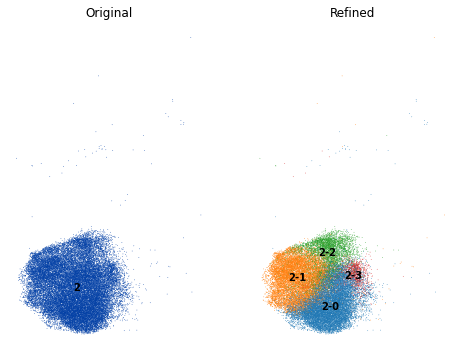

In [134]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

### Cluster 8 (TRAM4 (SOD2, CCL3, CCL4) and TRAM5 (MT1G))

In [135]:
ix = 8
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.1, ix)
adata.obs.update(adata_sub.obs)

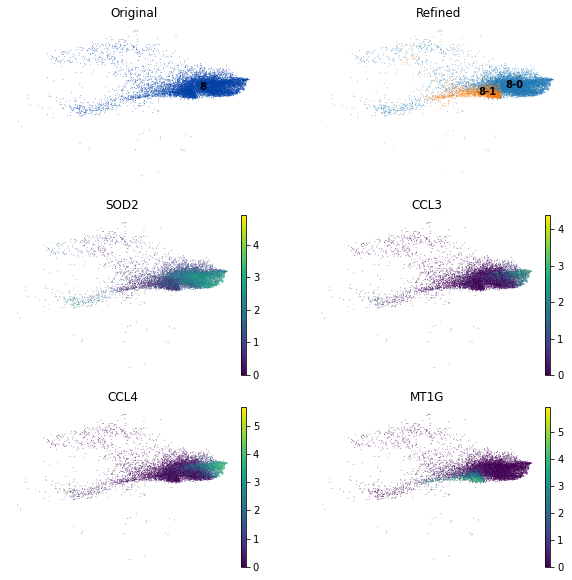

In [136]:
mpl.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(3, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0,0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[0,1]);
sc.pl.umap(adata_sub, color = "SOD2", legend_loc = "on data", frameon = False, title = "SOD2",
           size = 2, show = False, ax = ax[1,0]);
sc.pl.umap(adata_sub, color = "CCL3", legend_loc = "on data", frameon = False, title = "CCL3",
           size = 2, show = False, ax = ax[1,1]);
sc.pl.umap(adata_sub, color = "CCL4", legend_loc = "on data", frameon = False, title = "CCL4",
           size = 2, show = False, ax = ax[2,0]);
sc.pl.umap(adata_sub, color = "MT1G", legend_loc = "on data", frameon = False, title = "MT1G",
           size = 2, show = False, ax = ax[2,1]);

### Clusters 10 and 16 (DCs)

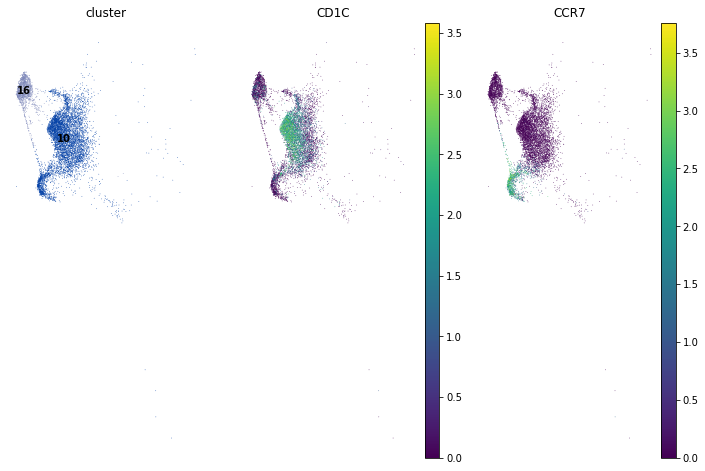

In [137]:
adata_sub = adata[adata.obs["leiden_scVI"].isin(["10", "16"])].copy()

mpl.rcParams["figure.figsize"] = (12, 8)
fig, ax = plt.subplots(1, 3)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "cluster",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "CD1C", legend_loc = "on data", frameon = False, title = "CD1C",
           size = 2, show = False, ax = ax[1]);
sc.pl.umap(adata_sub, color = "CCR7", legend_loc = "on data", frameon = False, title = "CCR7",
           size = 2, show = False, ax = ax[2]);

Perhaps cluster 10 should be reclustered. We'll recombine later if not.

In [138]:
ix = 10
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.1, ix)
adata.obs.update(adata_sub.obs)

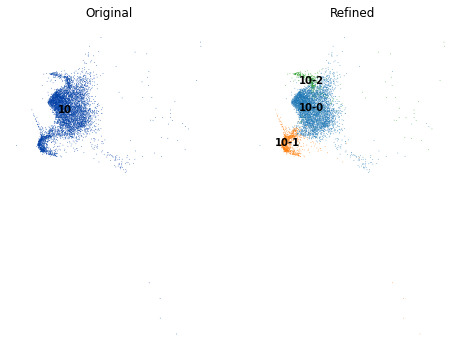

In [139]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

## Cluster 14 (monocytes)

In [140]:
ix = 14
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.1, ix)
adata.obs.update(adata_sub.obs)

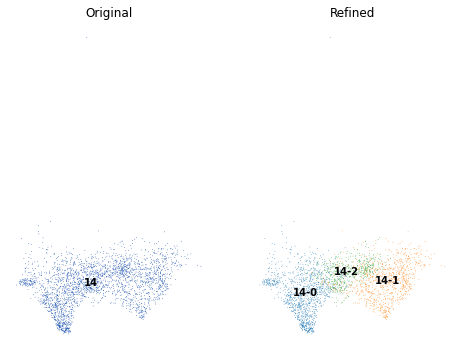

In [141]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

### Cluster 13
These looks like the FOXP3 Tregs which were not well resolved in the previous model.

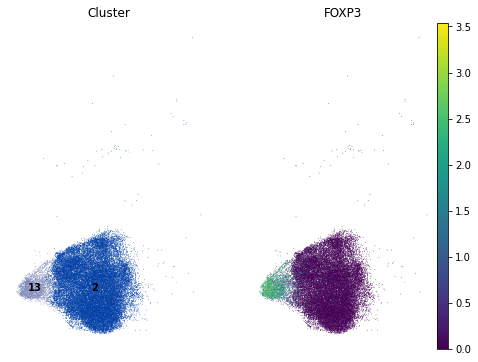

In [150]:
adata_sub = adata[adata.obs["leiden_scVI"].isin(["2", "13"])].copy()

mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Cluster",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "FOXP3", legend_loc = "on data", frameon = False, title = "FOXP3",
           size = 2, show = False, ax = ax[1]);

### Cluster 9 (proliferating macrophages and T cells)

In [158]:
ix = 9
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.1, ix)
adata.obs.update(adata_sub.obs)

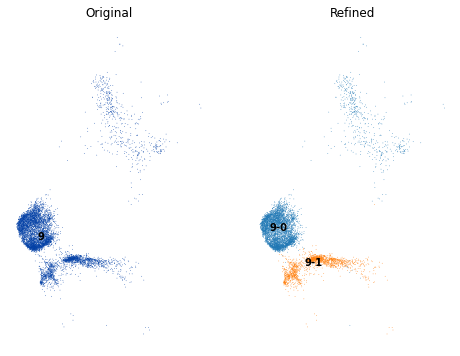

In [159]:
mpl.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 2)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[1]);

Based on the sankey below with the cell types from the old object (v4, before exon-only reprocessing), 9-0 is composed of proliferating TRAMs and 9-1 is composed of proliferating T cells.

### Cluster 6 (MoAM + perivascular macrophages)

In [192]:
ix = 6
adata_sub = adata[adata.obs["leiden_scVI"] == str(ix)].copy()
recluster(adata_sub, 0.25, ix)
adata.obs.update(adata_sub.obs)

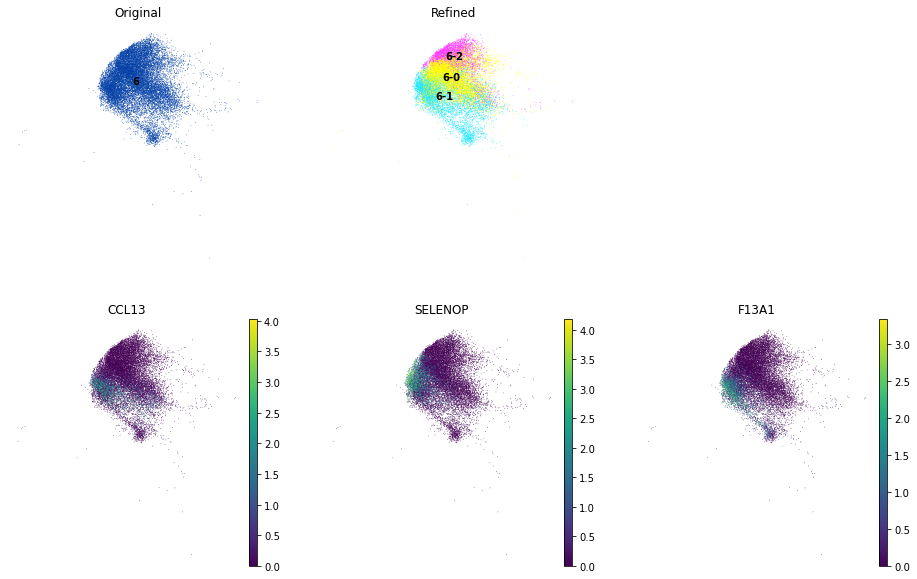

In [193]:
mpl.rcParams["figure.figsize"] = (16, 10)
fig, ax = plt.subplots(2, 3)
sc.pl.umap(adata_sub, color = "leiden_scVI", legend_loc = "on data", frameon = False, title = "Original",
           size = 2, show = False, ax = ax[0,0]);
sc.pl.umap(adata_sub, color = "subcluster", legend_loc = "on data", frameon = False, title = "Refined",
           size = 2, show = False, ax = ax[0,1]);
ax[0,2].axis('off');
sc.pl.umap(adata_sub, color = "CCL13", legend_loc = "on data", frameon = False, title = "CCL13",
           size = 2, show = False, ax = ax[1,0]);
sc.pl.umap(adata_sub, color = "SELENOP", legend_loc = "on data", frameon = False, title = "SELENOP",
           size = 2, show = False, ax = ax[1,1]);
sc.pl.umap(adata_sub, color = "F13A1", legend_loc = "on data", frameon = False, title = "F13A1",
           size = 2, show = False, ax = ax[1,2]);

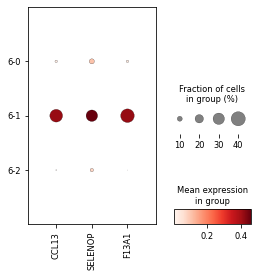

In [194]:
sc.pl.dotplot(adata_sub, ['CCL13', 'SELENOP', 'F13A1'], groupby = 'subcluster', figsize = [4, 4])

Cluster 6-1 looks to be the perivascular macrophages we had difficulty resolving before.

## Visualize refinements

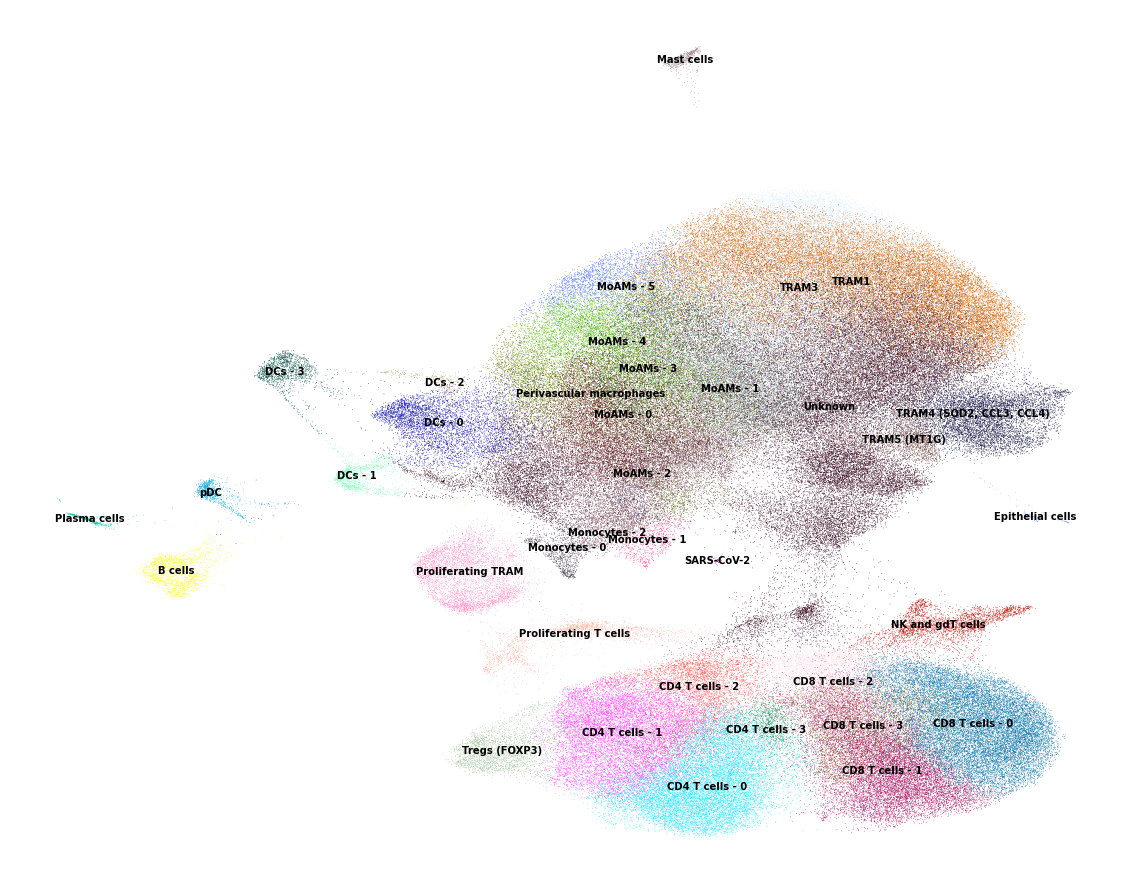

In [197]:
annotations = {"0-0" : "CD8 T cells - 0",
               "0-1" : "CD8 T cells - 1",
               "0-2" : "CD8 T cells - 2",
               "0-3" : "CD8 T cells - 3",
               "1-0" : "MoAMs - 0",
               "1-1" : "MoAMs - 1",
               "1-2" : "MoAMs - 2",
               "1-3" : "MoAMs - 3",
               "2-0" : "CD4 T cells - 0",
               "2-1" : "CD4 T cells - 1",
               "2-2" : "CD4 T cells - 2",
               "2-3" : "CD4 T cells - 3",
               "3" : "TRAM1",
               "4" : "Unknown",
               "5" : "TRAM3",
               "6-0" : "MoAMs - 4",
               "6-1" : "Perivascular macrophages",
               "6-2" : "MoAMs - 5",
               "7" : "Unknown",
               "8-0" : "TRAM4 (SOD2, CCL3, CCL4)",
               "8-1" : "TRAM5 (MT1G)",
               "9-0" : "Proliferating TRAM",
               "9-1" : "Proliferating T cells",
               "10-0" : "DCs - 0",
               "10-1" : "DCs - 1",
               "10-2" : "DCs - 2",
               "11" : "Unknown",
               "12" : "NK and gdT cells",
               "13" : "Tregs (FOXP3)",
               "14-0" : "Monocytes - 0",
               "14-1" : "Monocytes - 1",
               "14-2" : "Monocytes - 2",
               "15" : "B cells",
               "16" : "DCs - 3",
               "17" : "pDC",
               "18" : "Mast cells",
               "19" : "Plasma cells",
               "20" : "Epithelial cells",
               "21" : "SARS-CoV-2"}
adata.obs["cell_type"] = adata.obs['subcluster'].map(annotations).astype('category')

mpl.rcParams["figure.figsize"] = (20, 16)
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", frameon = False, title = "", size = 2)

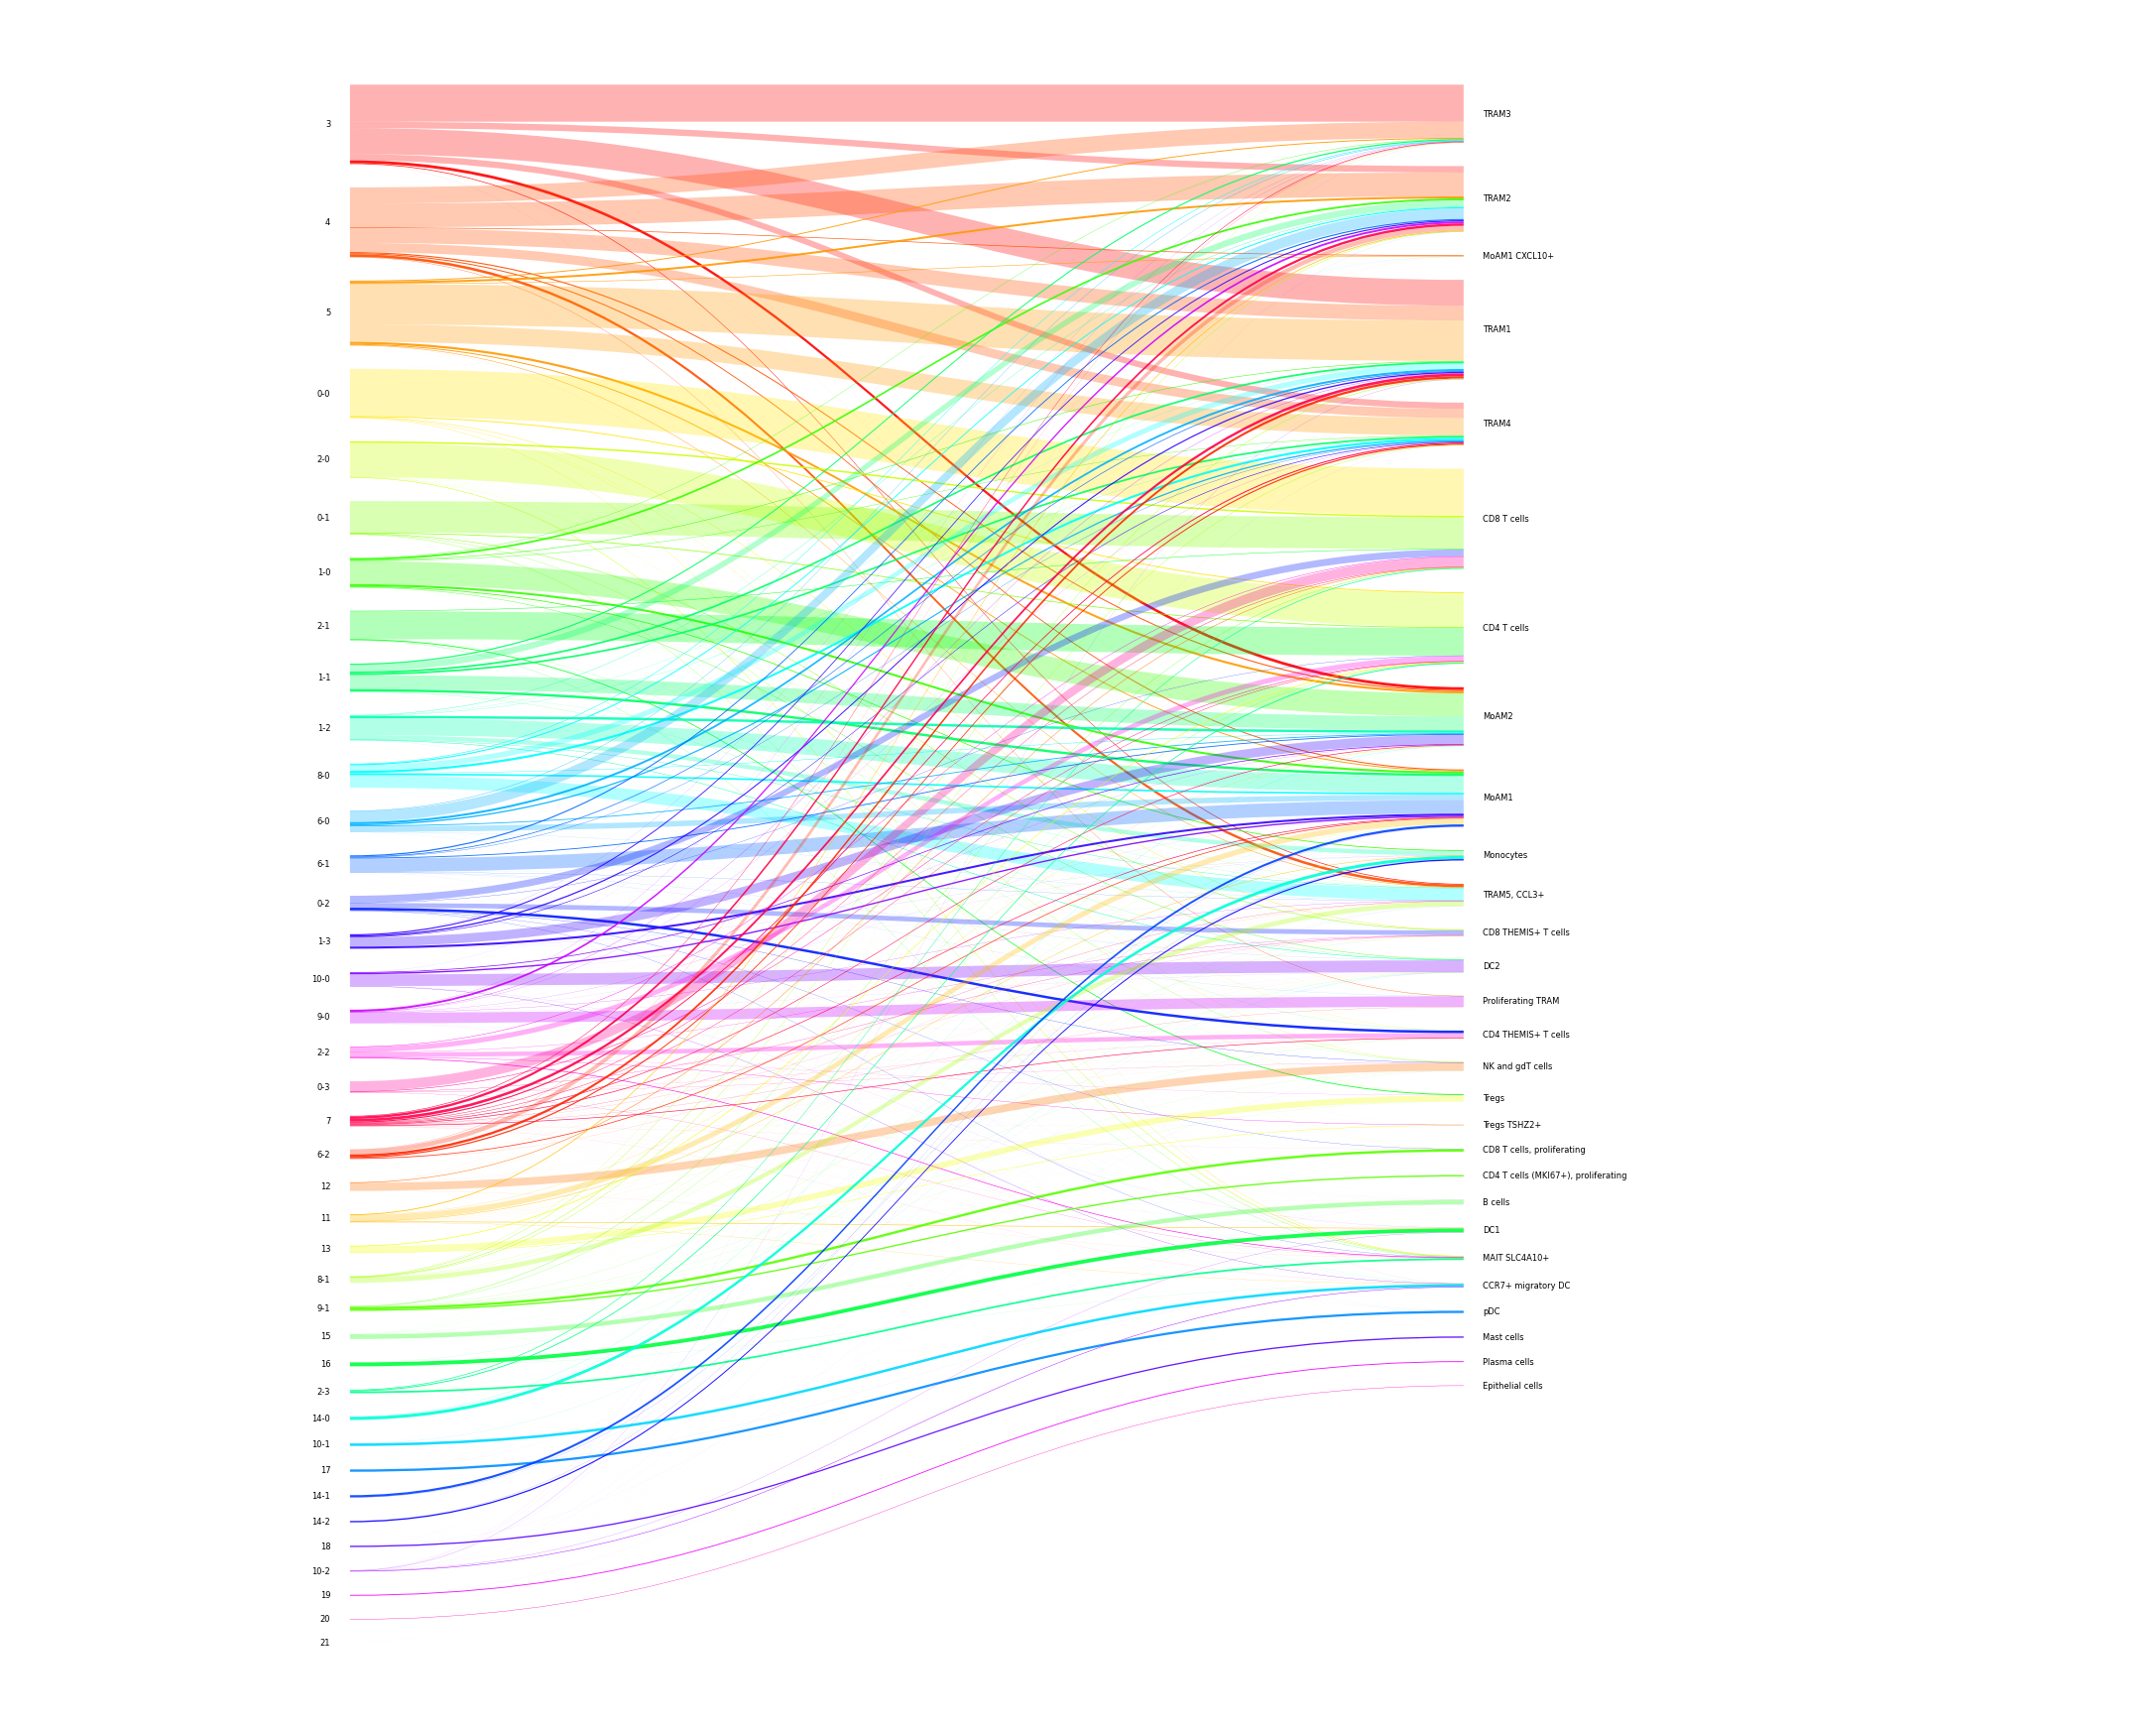

In [198]:
import sankey
adata_old = sc.read_h5ad(f"{data_dir}/01BAL/01integrated_BAL_v4/01integrated_BAL_v4.h5ad")
sankey_clusters = pd.merge(adata_old.obs["cell type"], adata.obs.subcluster, left_index = True, right_index = True)
sankey_clusters = sankey_clusters.rename(columns = {"subcluster":"new_cluster", "cell type":"cell_type"})

mpl.rcParams["figure.figsize"] = (30, 24)
sankey.sankey(sankey_clusters.new_cluster, sankey_clusters.cell_type);

## Compute marker genes

In [200]:
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, "subcluster", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [203]:
markers = sc_utils.get_markers(adata, "subcluster")
pd.options.display.max_rows = 500
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(10))

p_val  avg_logFC     pct.1     pct.2      p_val_adj  \
cluster                                                                     
0-0     0      0.000000e+00   5.138764  0.977726  0.219439   0.000000e+00   
        15     0.000000e+00   5.054719  0.683191  0.051711   0.000000e+00   
        28     0.000000e+00   4.679149  0.652452  0.054307   0.000000e+00   
        2      0.000000e+00   4.489364  0.791651  0.083262   0.000000e+00   
        21     0.000000e+00   4.307106  0.699275  0.071763   0.000000e+00   
        64     0.000000e+00   3.800524  0.547326  0.063631   0.000000e+00   
        166    0.000000e+00   3.794097  0.232633  0.021710   0.000000e+00   
        49     0.000000e+00   3.626798  0.620179  0.096872   0.000000e+00   
        162    0.000000e+00   3.609915  0.238559  0.025511   0.000000e+00   
        6      0.000000e+00   3.529830  0.931379  0.261988   0.000000e+00   
0-1     211    0.000000e+00   5.244035  0.639071  0.044145   0.000000e+00   
        200    0.000000e+00   5.006163  0.980300  0.237294   0.000000e+00   
        201    0.000000e+00   4.903594  0.904472  0.144850   0.000000e+00   
        216    0.000000e+00   4.296603  0.651266  0.074094   0.000000e+00   
        387   2.652065e-270   4.108344  0.198405  0.014825  2.652065e-270   
        202    0.000000e+00   4.094707  0.842089  0.160975   0.000000e+00   
        206    0.000000e+00   4.015455  0.738430  0.102704   0.000000e+00   
        219    0.000000e+00   3.886044  0.661976  0.088496   0.000000e+00   
        242    0.000000e+00   3.863963  0.558474  0.081466   0.000000e+00   
        205    0.000000e+00   3.725784  0.789790  0.161942   0.000000e+00   
0-2     401    0.000000e+00   3.864400  0.874569  0.259236   0.000000e+00   
        464   1.807022e-120   3.768850  0.205720  0.030568  1.807022e-120   
        442   2.485436e-186   3.617608  0.259649  0.043682  2.485436e-186   
        580    4.320050e-18   3.535664  0.079600  0.012532   4.320050e-18   
        413    0.000000e+00   3.448894  0.412819  0.078883   0.000000e+00   
        415    0.000000e+00   2.975888  0.414714  0.097217   0.000000e+00   
        420    0.000000e+00   2.923938  0.387491  0.091080   0.000000e+00   
        427   3.702472e-259   2.856320  0.334597  0.088192  3.702472e-259   
        419    0.000000e+00   2.840118  0.402998  0.108487   0.000000e+00   
        485    1.237520e-74   2.827581  0.181599  0.046207   1.237520e-74   
0-3     600    0.000000e+00   4.168494  0.958520  0.261506   0.000000e+00   
        787    2.918794e-85   3.603926  0.196795  0.021938   2.918794e-85   
        608    0.000000e+00   3.597168  0.760311  0.171547   0.000000e+00   
        619    0.000000e+00   3.586928  0.672637  0.106746   0.000000e+00   
        688    0.000000e+00   3.372386  0.427528  0.080607   0.000000e+00   
        623    0.000000e+00   3.281039  0.683007  0.124007   0.000000e+00   
        794    1.172412e-74   3.110222  0.190667  0.026571   1.172412e-74   
        660    0.000000e+00   3.063152  0.514966  0.090786   0.000000e+00   
        605    0.000000e+00   3.015702  0.840207  0.263915   0.000000e+00   
        610    0.000000e+00   2.996190  0.908555  0.299218   0.000000e+00   
1-0     829    0.000000e+00   2.992028  0.421819  0.070432   0.000000e+00   
        801    0.000000e+00   2.860605  0.757478  0.236110   0.000000e+00   
        822    0.000000e+00   2.751623  0.481033  0.107106   0.000000e+00   
        830    0.000000e+00   2.640291  0.449289  0.110207   0.000000e+00   
        900    0.000000e+00   2.430037  0.325368  0.087356   0.000000e+00   
        925    0.000000e+00   2.306218  0.316735  0.095188   0.000000e+00   
        871    0.000000e+00   2.236810  0.375251  0.111393   0.000000e+00   
        803    0.000000e+00   2.079471  0.854975  0.492496   0.000000e+00   
        977   4.350118e-279   2.069132  0.291009  0.107998  4.350118e-279   
        815    0.000000e+00   2.060672  0.594925  0.250859   0.000000e+00   
1-1     1074   0.0

## Save output

In [204]:
adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")